In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sp
from itertools import combinations, product

In [6]:
class ShortestConnectingPath:
    """
    Functor class for finding the shortest rho-length path between two sets of nodes.
    """

    # the dummy source and target node names
    src = '__source__'
    tgt = '__target__'
    
    def __init__(self, G, S, T):
                
        # remember the graph, source and target sets
        self.G = G
        self.S = S
        self.T = T
        
        # enumerate the edges so we can keep track of them
        # when processing a path
        for i, (u,v) in enumerate(G.edges()):
            G[u][v]['enum'] = i
        
        # make a copy of G to work on
        self.H = G.copy()
        
        # add dummy source and target nodes
        self.H.add_node(self.src)
        self.H.add_node(self.tgt)
        
        # link the dummy nodes
        for v in S:
            self.H.add_edge(self.src, v, rho=0)
        for v in T:
            self.H.add_edge(v, self.tgt, rho=0)
            
    def __call__(self, rho, tol):
        
        # assign rho to the graph edges
        for i, (u,v) in enumerate(self.G.edges()):
            self.H[u][v]['rho'] = rho[i]

        # find the shortest path
        p = nx.shortest_path(self.H, self.src, self.tgt, weight='rho')
        
        # the actual path omits the source and target dummy nodes
        p = p[1:-1]
        
        # form the row vector
        n = np.zeros(rho.shape)
        for i in range(len(p)-1):
            n[self.G[p[i]][p[i+1]]['enum']] = 1
            
        return p, n

def concurrent_matrix_modulus(N, f, d, p=2, sigma=None):
    """
    Computes the concurrent modulus of a family from its matrix representation.
    
    Parameters
    ----------
    N : numpy array OR scipy sparse matrix
        The N matrix for the family.
        
    f : numpy integer array
        Indices mapping the rows of N to the family id.
        
    d : numpy array
        Demands for the families.

    p : float or np.inf
        The modulus energy exponent.
        
    sigma : numpy array
        The weights sigma.  If sigma = None, all weights
        are treated as 1.
                
    Returns
    -------
    mod : float
        An approximation of the modulus.
        
    rho : numpy array
        An optimal rho^* for modulus.
        
    w   : numpy array
        An optimal w^* for modulus.
        
    lam : numpy array
        An optimal dual lambda^* for modulus.
        
    Notes
    -----
    This function is just a template solver.  For specialized
    problems, it is probably best to implement a particular
    solver based on the energy exponent and the desired
    tolerances in the approximation.
    """
    
    import cvxpy as cvx
    import numpy as np
    
    # problem dimension
    m  = N.shape[1]
    n  = N.shape[0]
    nf = len(d)
    
    # set sigma to default if necessary
    if sigma is None:
        sigma = np.ones(m)
    
    # convert inputs to cvxpy constants
    N = cvx.Constant(N)
    sigma = cvx.Constant(sigma)
    
    # primal variables
    rho = cvx.Variable(m)
    w   = cvx.Variable(nf)
        
    # objective
    if p is not np.inf:
        obj = cvx.Minimize(sigma.T*rho**p)
    else:
        obj = cvx.Minimize(cvx.max(cvx.multiply(sigma, rho)))
        
    # constraints
    I = range(n)
    J = f
    V = [1.]*n
    B = sp.csr_matrix((V,(I,J)), shape=(n,nf))
    cons = [rho >= 0, w >= 0, d*w >= 1, N*rho >= B*w]
    
    # set up the problem
    prob = cvx.Problem(obj, cons)
    
    # attempt to solve
    prob.solve(solver='ECOS')
    if prob.status != 'optimal':
        warn('cvxpy solve returned status {}'.format(prob.status))
        
    # round rho and w to be positive
    rho = np.array(rho.value).flatten()
    rho[rho <0] = 0
    w = np.array(w.value).flatten()
    w[w <0] = 0
        
    return prob.value, rho, w, np.array(cons[3].dual_value).flatten()

def concurrent_modulus(m, solve_subproblem, find_shortest, d, p = 2, sigma = None, tol = 1e-3, 
                       max_iter = 1000, output_every = None):
    """
    Implements the basic algorithm for modulus.
    
    Parameters
    ----------
    m : int
        The dimension of the modulus problem (number of edges).
        
    solve_subproblem : callable
        See below.
        
    find_shortest : list of callable
        See below.
        
    d : numpy array
        The demands corresponding to the find_shortest list.

    p : float or np.inf
        The modulus energy exponent.
        
    sigma : numpy array
        The weights sigma.  If sigma = None, all weights
        are treated as 1.
        
    tol : float
        The tolerance.  The modulus algorithm stops when the approximate
        density is within tol of being admissible.
        
    max_iter : int
        Maximum number of iterations to perform before terminating with an error.
        
    output_every : int
        Frequency of output to stderr.  If this is set to None, output is supressed.
        
    Returns
    -------
    mod : float
        Approximation to modulus.
        
    cons : list
        List of constraints added during the iteration.  The format of the elements of
        this list is determined by the output of the find_violated_constraint function.
        
    rho : numpy array
        Approximation to an optimal density.
        
    lam : numpy array
        Approximation to the dual variables for the constraints listed in cons.
        
    Notes
    -----
    The function solve_subproblem should have the following signature
    
        mod, rho, lam = solve_subproblem(N, f, d, p, sigma)
        
    See the function concurrent_matrix_modulus for an example.
    
    The functions in find_shortest should have the following signature
    
        cons, n = find_shortest[i](rho, tol)
        
    Each function should find a "most violated constraint" using the specified values
    for rho.  Upon return, cons may contain any representation desired for describing
    the constraint.  (This is purely informational for the user and it is acceptable
    for cons to be set to None.)  n should contain the numpy row vector representing the
    violated constraint.  This is the row that will be added to N on the next iteration.
    
    The argument tol may be ignored.  However, it is acceptable for the function to return
    the tuple (None, None) if every constraint is satisfied to within a tolerance of tol.
    """
    
    import numpy as np
    import scipy.sparse as sp
    from time import perf_counter
    
    # timers
    search_time = 0.
    update_time = 0.
    mod_start = perf_counter()
    
    # initialize variables
    rho = np.zeros(m)
    nf = len(d)
    w = 1/(nf*d)
    N = sp.csr_matrix((0,m))
    lam = np.array([])
    f = np.array([],dtype=int)
    mod = 0.
    upper = np.inf
    cons = []
    
    # default sigma
    if sigma is None:
        sigma = np.ones(m)
    
    # initialize output table
    if output_every:
        print('| {:>6s} | {:>9s} | {:>9s} | {:>9s} | {:>6s} | {:>9s} |' \
            .format( 'it', 'l bnd', 'u bnd', 'rel gap', '# cons', 'time (s)' ))
        print('+--------+-----------+-----------+-----------+--------+-----------+')

    # loop to at most max_iter
    for iter_count in range(max_iter):
                
        # find a constraint to add
        start = perf_counter()
        c, n, fam = None, None, None
        alpha = np.Inf
        for i in range(nf):
            if w[i] == 0:
                continue
            ci, ni = find_shortest[i](rho, tol)
            if ni is None:
                continue
            alpha_i = ni.dot(rho)/w[i]
            if alpha_i < alpha:
                c, n, alpha, fam = ci, ni, alpha_i, i
        search_time += perf_counter()-start
        
        # compute the length of the shortest object
        if n is None:
            length = 1.
        else:
            length = alpha
            
        # update the upper bound
        if length > 0:
            if p is np.Inf:
                upper = np.abs(sigma*rho/length)
            else:
                upper = np.sum(sigma*(rho/length)**p)
            
        # check if we can stop
        if length > 1-tol:
            if output_every:
                print('| {:6d} | {:9.3e} | {:9.3e} | {:9.3e} | {:6d} | {:9.3e} |' \
                    .format( iter_count+1, mod, upper, (upper-mod)/mod, N.shape[0], perf_counter() - mod_start ))

                print()
                print('program running time = {} sec'.format( perf_counter() - mod_start ))
                print('constraint search    = {} sec'.format( search_time ))
                print('solution update      = {} sec'.format( update_time ))

            return mod, cons, rho, w, lam
        
        # if not, we need to add a constraint
        N = sp.vstack([N,n], format='csr')
        f = np.append(f, fam)
        cons.append(c)
        
        # re-optimize
        start = perf_counter()
        mod, rho, w, lam =solve_subproblem(N, f, d, p, sigma)
        update_time += perf_counter()-start        
        
        # print some feedback if desired
        if output_every and (iter_count+1) % output_every == 0:
            if mod == 0:
                rel_gap = np.inf
            else:
                rel_gap = (upper-mod)/mod
            print('| {:6d} | {:.3e} | {:.3e} | {:.3e} | {:6d} | {:.3e} |' \
                .format( iter_count+1, mod, upper, rel_gap, N.shape[0], perf_counter() - mod_start ))

        
    # if we got here, we failed to converge
    raise RuntimeError('Modulus algorithm failed to converge in {} iterations.'.format(max_iter))

## Example 5.1

### $p=1$

In [3]:
print('|  approx |   true  |     err     |')
print('+---------+---------+-------------+')

G = nx.path_graph(4)
families = [ShortestConnectingPath(G,set([u]),set([v])) for (u,v) in ((0,2), (1,3))]

m = len(G.edges)

for t in range(20):
    sigma = np.random.rand(3)
    d = np.random.rand()
    d = np.array([d,1-d])
    mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                                d, sigma=sigma, p=1, tol=1e-8)

    true_mod = np.min([sigma[0]/d[0],sigma[1],sigma[2]/d[1]])
    err = abs(mod-true_mod)/abs(true_mod)
    print('| {:.5f} | {:.5f} | {:.5e} |'.format(mod, true_mod, err))

|  approx |   true  |     err     |
+---------+---------+-------------+


| 0.53387 | 0.53387 | 2.46641e-10 |
| 0.09982 | 0.09982 | 7.13657e-10 |
| 0.83597 | 0.83597 | 4.45627e-10 |
| 0.17400 | 0.17400 | 8.36845e-11 |
| 0.19112 | 0.19112 | 7.11277e-10 |
| 0.24842 | 0.24842 | 6.92196e-12 |


| 0.55483 | 0.55483 | 6.52298e-11 |
| 0.80566 | 0.80566 | 7.89684e-11 |
| 0.16384 | 0.16384 | 2.51547e-09 |
| 0.29496 | 0.29496 | 5.79263e-10 |
| 0.61740 | 0.61740 | 3.95122e-10 |
| 0.25772 | 0.25772 | 8.07711e-10 |
| 0.37027 | 0.37027 | 3.06693e-10 |
| 0.70365 | 0.70365 | 2.57040e-10 |
| 0.97965 | 0.97965 | 2.21194e-09 |


| 0.93133 | 0.93133 | 4.34374e-11 |
| 0.34965 | 0.34965 | 3.88711e-12 |
| 0.27131 | 0.27131 | 6.75560e-10 |
| 0.07853 | 0.07853 | 7.33776e-10 |


| 0.53022 | 0.53022 | 1.54176e-10 |


### $p = 2$

In [4]:
print('|  approx |   true  |     err     |')
print('+---------+---------+-------------+')
G = nx.path_graph(4)
families = [ShortestConnectingPath(G,set([u]),set([v])) for (u,v) in ((0,2), (1,3))]

m = len(G.edges)

for t in range(20):
    sigma = np.random.rand(3)
    d = np.random.rand()
    d = np.array([d,1-d])
    mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                                d, sigma=sigma, p=2, tol=1e-8)

    true_mod = 1/(d[0]**2/sigma[0] + 1/sigma[1] + d[1]**2/sigma[2])
    err = abs(mod-true_mod)/abs(true_mod)
    print('| {:.5f} | {:.5f} | {:.5e} |'.format(mod, true_mod, err))

|  approx |   true  |     err     |
+---------+---------+-------------+
| 0.32645 | 0.32645 | 4.96998e-10 |
| 0.26470 | 0.26470 | 1.35072e-10 |
| 0.07992 | 0.07992 | 2.35889e-10 |


| 0.10782 | 0.10782 | 1.32107e-09 |
| 0.08909 | 0.08909 | 9.31271e-10 |
| 0.47760 | 0.47760 | 1.26690e-09 |
| 0.20000 | 0.20000 | 9.20792e-10 |
| 0.25092 | 0.25092 | 1.28938e-09 |
| 0.38127 | 0.38127 | 8.95223e-10 |


| 0.14630 | 0.14630 | 2.41695e-10 |
| 0.27856 | 0.27856 | 4.32795e-10 |
| 0.04892 | 0.04892 | 1.73949e-10 |
| 0.25258 | 0.25258 | 9.08572e-10 |
| 0.15864 | 0.15864 | 5.34896e-11 |


| 0.15396 | 0.15396 | 8.70214e-10 |
| 0.42384 | 0.42384 | 1.03314e-09 |
| 0.21329 | 0.21329 | 2.13588e-10 |
| 0.44742 | 0.44742 | 1.04846e-09 |
| 0.05903 | 0.05903 | 3.45494e-10 |


| 0.35436 | 0.35436 | 2.75609e-10 |


### $p=\infty$

In [5]:
print('|  approx |   true  |     err     |')
print('+---------+---------+-------------+')
G = nx.path_graph(4)
families = [ShortestConnectingPath(G,set([u]),set([v])) for (u,v) in ((0,2), (1,3))]

m = len(G.edges)

for t in range(20):
    sigma = np.random.rand(3)
    d = np.random.rand()
    d = np.array([d,1-d])
    mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                                d, sigma=sigma, p=np.Inf, tol=1e-8)

    true_mod = 1/(d[0]/sigma[0] + 1/sigma[1] + d[1]/sigma[2])
    err = abs(mod-true_mod)
    print('| {:.5f} | {:.5f} | {:.5e} |'.format(mod, true_mod, err))

|  approx |   true  |     err     |
+---------+---------+-------------+
| 0.31204 | 0.31204 | 3.96249e-10 |
| 0.17384 | 0.17384 | 4.57802e-10 |
| 0.33960 | 0.33960 | 3.75058e-10 |
| 0.25733 | 0.25733 | 1.67518e-10 |
| 0.16613 | 0.16613 | 4.76907e-11 |


| 0.42021 | 0.42021 | 5.06829e-11 |
| 0.16405 | 0.16405 | 2.06043e-11 |
| 0.37063 | 0.37063 | 3.50177e-10 |
| 0.11180 | 0.11180 | 9.55122e-11 |
| 0.28448 | 0.28448 | 1.15393e-09 |
| 0.13747 | 0.13747 | 6.35914e-11 |
| 0.13626 | 0.13626 | 3.65388e-12 |


| 0.17812 | 0.17812 | 1.50094e-09 |
| 0.10445 | 0.10445 | 5.25840e-10 |
| 0.19738 | 0.19738 | 4.38767e-10 |
| 0.17837 | 0.17837 | 4.24649e-10 |
| 0.11065 | 0.11065 | 6.65328e-11 |
| 0.09636 | 0.09636 | 1.49421e-11 |
| 0.09860 | 0.09860 | 4.39568e-12 |


| 0.02611 | 0.02611 | 3.66949e-12 |


## Example 5.2

In [6]:
G = nx.cycle_graph(3)
families = [ShortestConnectingPath(G,set([u]),set([v])) for (u,v) in ((0,1), (0,2))]

m = len(G.edges)

d = np.array([1,2])
mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                            d, p=2, tol=1e-8)

print('approx mod = ', mod)
print('true mod   = ', 3/14)
print('error      = ', abs(mod-3/14))

approx mod =  0.2142857138892306
true mod   =  0.21428571428571427
error      =  3.9648367922140437e-10


## $K_{m,n}$

In [7]:
print('| m | n |  mod_1  |  mod_2  | mod_inf |  mod_1 err  |  mod_2 err  | mod_inf err |')
print('+---+---+---------+---------+---------+-------------+-------------+-------------+')
for n1 in range(1,6):
    for n2 in range(1,n1+1):

        G = nx.complete_bipartite_graph(n1, n2)
        families = [ShortestConnectingPath(G,set([u]),set([v])) for u,v in combinations(G.nodes,2)]
        nf = len(families)
        d = np.ones(nf)/nf
        m = len(G.edges)

        true_mod_1 = 1/(2/(n1*n2) - d[0])
        true_mod_2 = 1/(n1*n2*(2/(n1*n2) - d[0])**2)
        true_mod_inf = 1/(2-n1*n2*d[0])

        mod_1, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                                    d, p=1, tol=1e-4)
        mod_2, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                                    d, p=2, tol=1e-4)
        mod_inf, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, 
                                                    d, p=np.Inf, tol=1e-4)
        err_1 = abs(mod_1-true_mod_1)
        err_2 = abs(mod_2-true_mod_2)
        err_inf = abs(mod_inf-true_mod_inf)

        print('| {} | {} | {:7.4f} | {:7.4f} | {:7.4f} | {:.5e} | {:.5e} | {:.5e} |'.\
              format(n1, n2, mod_1, mod_2, mod_inf, err_1, err_2, err_inf))

| m | n |  mod_1  |  mod_2  | mod_inf |  mod_1 err  |  mod_2 err  | mod_inf err |
+---+---+---------+---------+---------+-------------+-------------+-------------+
| 1 | 1 |  1.0000 |  1.0000 |  1.0000 | 9.34634e-10 | 1.55110e-10 | 1.16066e-09 |


| 2 | 1 |  1.5000 |  1.1250 |  0.7500 | 2.03658e-10 | 1.69494e-10 | 9.16281e-11 |


| 2 | 2 |  3.0000 |  2.2500 |  0.7500 | 1.55841e-10 | 1.25687e-10 | 4.60620e-12 |


| 3 | 1 |  2.0000 |  1.3333 |  0.6667 | 1.24716e-10 | 1.25217e-10 | 9.31748e-11 |


| 3 | 2 |  4.2857 |  3.0612 |  0.7143 | 5.18510e-11 | 1.18622e-09 | 1.45862e-11 |


| 3 | 3 |  6.4286 |  4.5918 |  0.7143 | 1.21183e-11 | 2.88603e-09 | 4.31686e-11 |


| 4 | 1 |  2.5000 |  1.5625 |  0.6250 | 8.26468e-11 | 1.40072e-09 | 9.61697e-12 |


| 4 | 2 |  5.4545 |  3.7190 |  0.6818 | 7.00062e-12 | 2.26582e-09 | 3.45404e-11 |


| 4 | 3 |  8.4000 |  5.8800 |  0.7000 | 8.09646e-11 | 5.54943e-10 | 5.93581e-11 |


| 4 | 4 | 11.2000 |  7.8400 |  0.7000 | 1.25926e-11 | 6.24256e-09 | 1.97176e-12 |


| 5 | 1 |  3.0000 |  1.8000 |  0.6000 | 2.79918e-10 | 1.04416e-09 | 1.79263e-11 |


| 5 | 2 |  6.5625 |  4.3066 |  0.6563 | 9.21752e-12 | 2.08435e-09 | 9.00818e-11 |


| 5 | 3 | 10.2439 |  6.9958 |  0.6829 | 5.43565e-12 | 3.27829e-09 | 1.65057e-12 |


| 5 | 4 | 13.8462 |  9.5858 |  0.6923 | 2.40503e-10 | 4.50923e-10 | 2.15106e-12 |


| 5 | 5 | 17.3077 | 11.9822 |  0.6923 | 1.92422e-10 | 9.78090e-09 | 3.56759e-12 |


In [8]:
layer_sizes = [4, 8, 4, 8, 4, 1]
begin = np.cumsum([0] + layer_sizes)

G = nx.Graph()
for i in range(len(layer_sizes)-1):
    for j in range(layer_sizes[i]):
        for k in range(layer_sizes[i+1]):
            G.add_edge(begin[i]+j,begin[i+1]+k)
            
pos = {}
v = 0
for i in range(len(layer_sizes)):
    for j in range(layer_sizes[i]):
        pos[v] = (i,j-layer_sizes[i]/2)
        v += 1

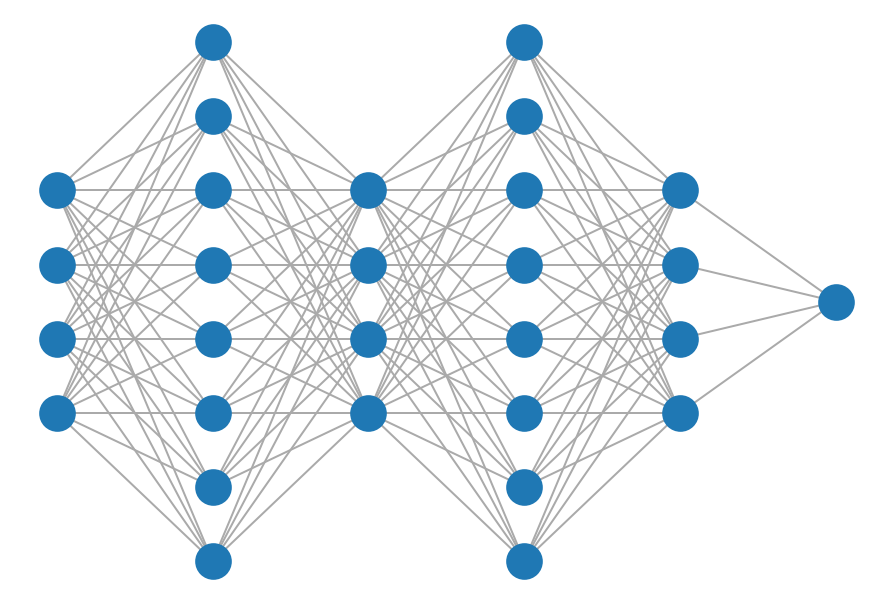

In [9]:
nx.draw(G,pos,edge_color='#aaaaaa')

In [11]:
n = len(G.nodes)
families = [ShortestConnectingPath(G,set([u]),set([n-1-v])) for u in range(layer_sizes[0]) for v in range(layer_sizes[-1])]
nf = len(families)
d = np.ones(nf)/nf
m = len(G.edges)
mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, d, p=2,
                                            tol=1e-4, output_every=10)


|     it |     l bnd |     u bnd |   rel gap | # cons |  time (s) |
+--------+-----------+-----------+-----------+--------+-----------+


|     10 | 1.429e+00 | 1.441e+01 | 9.084e+00 |     10 | 5.047e-01 |


|     20 | 2.174e+00 | 8.800e+00 | 3.048e+00 |     20 | 7.354e-01 |


|     30 | 2.580e+00 | 6.506e+00 | 1.522e+00 |     30 | 1.056e+00 |
|     34 | 2.667e+00 | 2.667e+00 | 1.396e-05 |     33 | 1.158e+00 |

program running time = 1.1585924009996234 sec
constraint search    = 0.15707144899351988 sec
solution update      = 0.961829435051186 sec


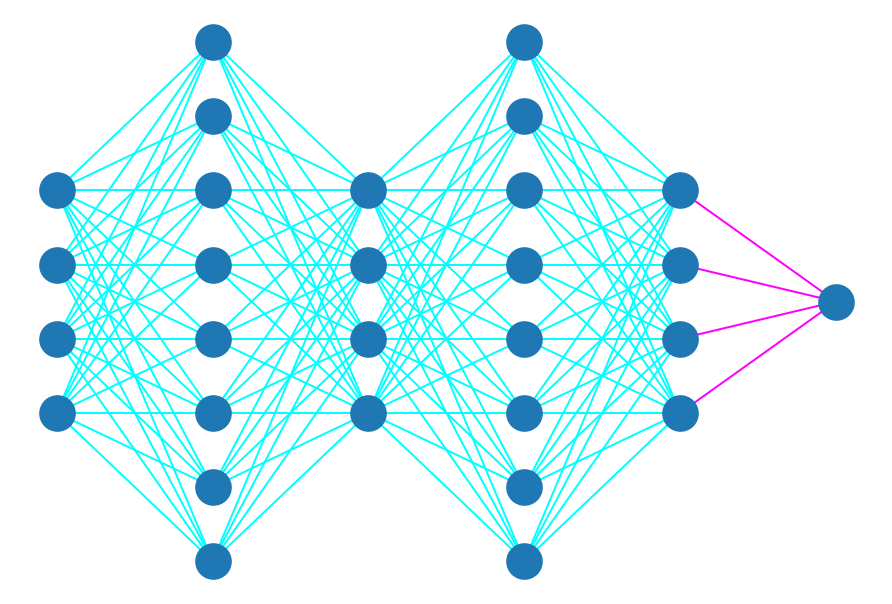

In [12]:
nx.draw(G,pos,edge_color='white')
nx.draw_networkx_edges(G, pos, edge_color=rho, edge_cmap=plt.cm.cool)

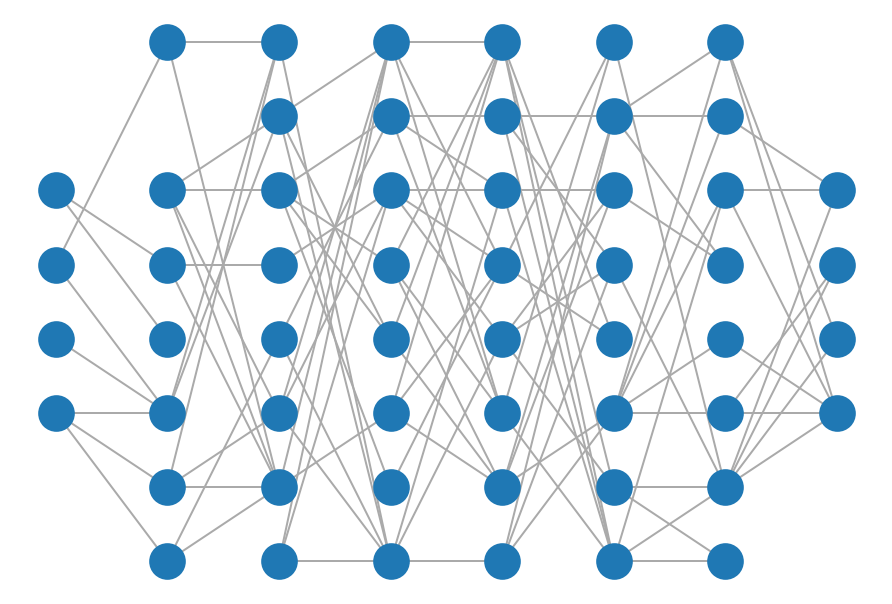

In [14]:
np.random.seed(3810192)
layer_sizes = [4, 8, 8, 8, 8, 8, 8, 4]
p = 0.25
begin = np.cumsum([0] + layer_sizes)

G = nx.Graph()
for i in range(len(layer_sizes)-1):
    for j in range(layer_sizes[i]):
        for k in range(layer_sizes[i+1]):
            if np.random.rand() < p:
                G.add_edge(begin[i]+j,begin[i+1]+k)
            
pos = {}
v = 0
for i in range(len(layer_sizes)):
    for j in range(layer_sizes[i]):
        pos[v] = (i,j-layer_sizes[i]/2)
        v += 1
        
nx.draw(G,pos,edge_color='#aaaaaa')

In [0]:
n = len(G.nodes)
families = [ShortestConnectingPath(G,set([u]),set([n-1-v])) for u in range(layer_sizes[0]) for v in range(layer_sizes[-1])]
nf = len(families)
d = np.ones(nf)/nf
m = len(G.edges)
mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, d, p=2,
                                            tol=1e-4, output_every=10)


In [0]:
nx.draw(G,pos,edge_color='white')
nx.draw_networkx_edges(G, pos, edge_color=rho, edge_cmap=plt.cm.cool)

## Ternary Lattice


In [7]:
def ternary_graph(d, n):
    G = nx.Graph()
    for i in product(range(n),repeat=d):
        if sum(i) >= n:
            continue
        for j in range(d):
            for o in (-1,1):
                k = list(i)
                k[j] += o
                k = tuple(k)
                if sum(k) < n and min(k) >= 0:
                    G.add_edge(i,k)
        for j,l in combinations(range(d),2):
            for o in (-1,1):
                k = list(i)
                k[j] += o
                k[l] -= o
                k = tuple(k)
                if sum(k) < n and min(k) >= 0:
                    G.add_edge(i,k)
    return G

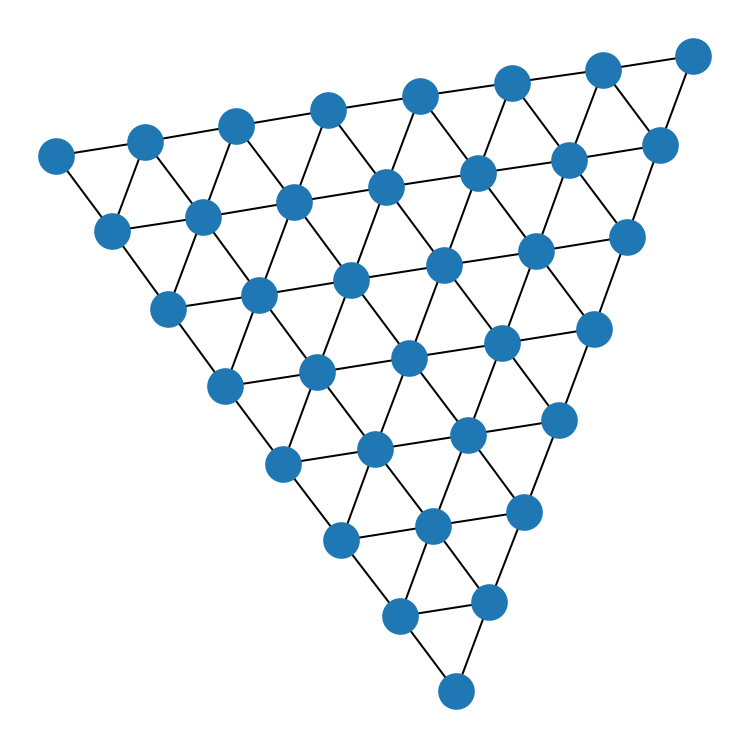

In [18]:
r, n = 2, 8
G = ternary_graph(r, n)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(5,5))
nx.draw(G,pos)

In [20]:
vertices = [(0,)*r]
for i in range(r):
    v = [0]*r
    v[i] = n-1
    vertices.append(tuple(v))

families = [ShortestConnectingPath(G,set([u]),set([v])) for u,v in combinations(vertices,2)]

nf = len(families)
d = np.ones(nf)/nf
m = len(G.edges)
mod, cons, rho, w, lam = concurrent_modulus(m, concurrent_matrix_modulus, families, d, p=2,
                                            tol=1e-4, output_every=10)

|     it |     l bnd |     u bnd |   rel gap | # cons |  time (s) |
+--------+-----------+-----------+-----------+--------+-----------+


|     10 | 6.920e-01 | 1.183e+00 | 7.093e-01 |     10 | 1.714e+00 |


|     20 | 7.127e-01 | 7.757e-01 | 8.835e-02 |     20 | 1.940e+00 |


|     30 | 7.153e-01 | 7.426e-01 | 3.814e-02 |     30 | 2.217e+00 |


|     40 | 7.159e-01 | 7.240e-01 | 1.138e-02 |     40 | 2.533e+00 |
|     49 | 7.159e-01 | 7.159e-01 | 2.992e-06 |     48 | 2.715e+00 |

program running time = 2.7148516990000644 sec
constraint search    = 0.09546411600194915 sec
solution update      = 2.5670153819992265 sec


In [22]:
w

array([1.00000014, 1.00000009, 0.99999978])

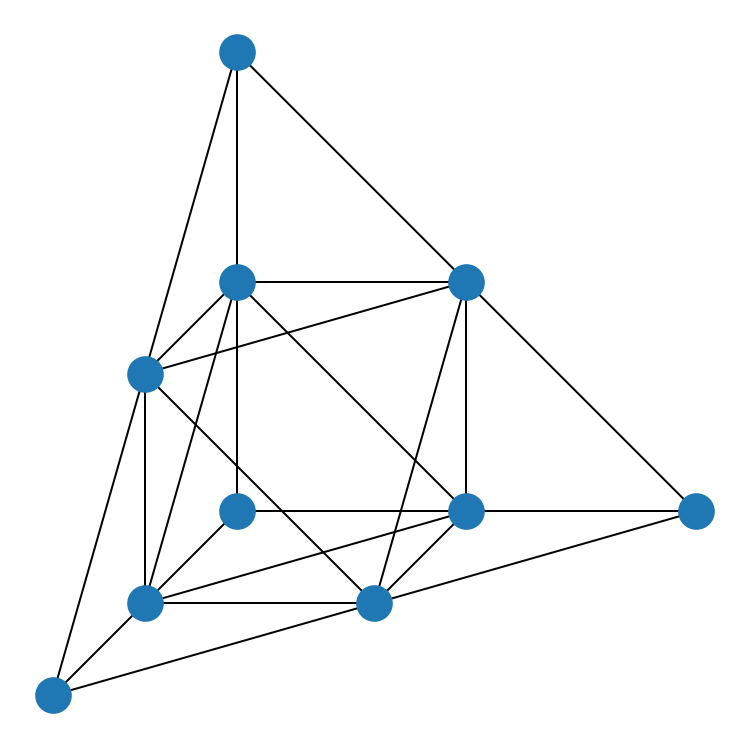

In [11]:
n = 3
G = ternary_graph(3,n)
pos = {}
for i,j,k in G.nodes:
    pos[(i,j,k)] = (j-0.4*i, k-0.4*i)
plt.figure(figsize=(5,5))
nx.draw(G,pos)

[(0, 0, 0)]


NameError: name 'blah' is not defined